In [55]:
import pandas as pd
import pandas_datareader
from pandas_datareader import get_data_yahoo as yh
import itertools
from telegram import *
from telegram.ext import *
import time
import requests
import schedule
import datetime

asset_count=5
ma_short=15
ma_long=50
pv_period=5
key="1625635210:AAGhRy5wwFipBoRmUG8Z3bUTklS9h5agGGc"

In [12]:
myassetlist = [
    'TSLA',
    'GOOG',
    'AAPL',
    'SPY',
    'XLI',
    'GME',
    'AMC',
    'BB',
    'NOK',
    'NAKD',
    'PSA'
]

In [13]:
df = yh(myassetlist)['Close'] # Get close prices

In [14]:
df.to_csv('data.csv') # run this if you wanna export to csv

In [15]:
# Get 20 day returns and rank
ranked_assets = pd.DataFrame(df.pct_change(20).mean().sort_values(ascending = False)) # Ascending to descending returns
ranked_assets # full assets

,0
Symbols,
GME,0.082048
TSLA,0.066060
AAPL,0.030958
NAKD,0.028841
BB,0.023662
AMC,0.019069
GOOG,0.018993
SPY,0.011878
XLI,0.010106


In [16]:
#moving average short/long term
ranked_ma_assets = pd.DataFrame(((df.tail(ma_short).mean()-df.tail(ma_long).mean())/df.tail(ma_long).mean()).sort_values(ascending = False))
ranked_ma_to_trade = pd.concat([ranked_ma_assets.head(asset_count),ranked_ma_assets.tail(asset_count)])
ranked_ma_to_trade['Direction']= -1
for row in ranked_ma_to_trade.head(asset_count):
    ranked_ma_to_trade.head(asset_count)['Direction']= 1
ranked_ma_to_trade.columns = ['MA_strategy','Direction']
ranked_ma_to_trade

C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,MA_strategy,Direction
Symbols,,
NAKD,1.029594,1
AMC,0.571870,1
GME,0.558353,1
BB,0.204225,1
GOOG,0.102263,1
NOK,0.024848,-1
PSA,0.024319,-1
SPY,0.023735,-1
AAPL,0.017040,-1


In [17]:
#Price ratio
#list(itertools.combinations(myassetlist, 2))

In [18]:
#VPT indicator
vf=yh(myassetlist)['Volume']
ranked_pv_assets = pd.DataFrame(((vf*df.pct_change()).cumsum()).pct_change(pv_period).tail(1).sum().sort_values(ascending = False))
ranked_pv_to_trade = pd.concat([ranked_pv_assets.head(asset_count),ranked_pv_assets.tail(asset_count)])
ranked_pv_to_trade['Direction']= -1
for row in ranked_pv_to_trade.head(asset_count):
    ranked_pv_to_trade.head(asset_count)['Direction']= 1
ranked_pv_to_trade.columns = ['VPT_strategy','Direction']
ranked_pv_to_trade

C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,VPT_strategy,Direction
Symbols,,
SPY,0.002025,1
AMC,0.000063,1
NOK,-0.000160,1
TSLA,-0.002040,1
NAKD,-0.002494,1
PSA,-0.009863,-1
BB,-0.010752,-1
XLI,-0.019914,-1
AAPL,-0.023631,-1


In [19]:
long = ranked_assets[0:asset_count] # top 2 assets
long['Direction'] = 1
long.columns = ['20_day_returns','Direction']
long

C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,20_day_returns,Direction
Symbols,,
GME,0.082048,1
TSLA,0.066060,1
AAPL,0.030958,1
NAKD,0.028841,1
BB,0.023662,1


In [20]:
short = ranked_assets[-asset_count:] # bottom 2 assets
short['Direction'] = -1
short.columns = ['20_day_returns','Direction']
short

C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,20_day_returns,Direction
Symbols,,
GOOG,0.018993,-1
SPY,0.011878,-1
XLI,0.010106,-1
NOK,0.000959,-1
PSA,-0.000158,-1


In [21]:
assets_to_trade = pd.concat([long,short])

In [22]:
assets_to_trade

,20_day_returns,Direction
Symbols,,
GME,0.082048,1
TSLA,0.066060,1
AAPL,0.030958,1
NAKD,0.028841,1
BB,0.023662,1
GOOG,0.018993,-1
SPY,0.011878,-1
XLI,0.010106,-1
NOK,0.000959,-1


# Combine strategies

In [49]:
combined = pd.DataFrame(pd.concat([assets_to_trade,ranked_ma_to_trade,ranked_pv_to_trade])['Direction'])
combined = combined.reset_index()
combined = combined.groupby('Symbols').sum().sort_values('Direction',ascending=False)

C:\Users\Clara\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [50]:
combined

,Direction
Symbols,
NAKD,3
AMC,2
GME,2
TSLA,2
BB,1
AAPL,-1
GOOG,-1
NOK,-1
SPY,-1


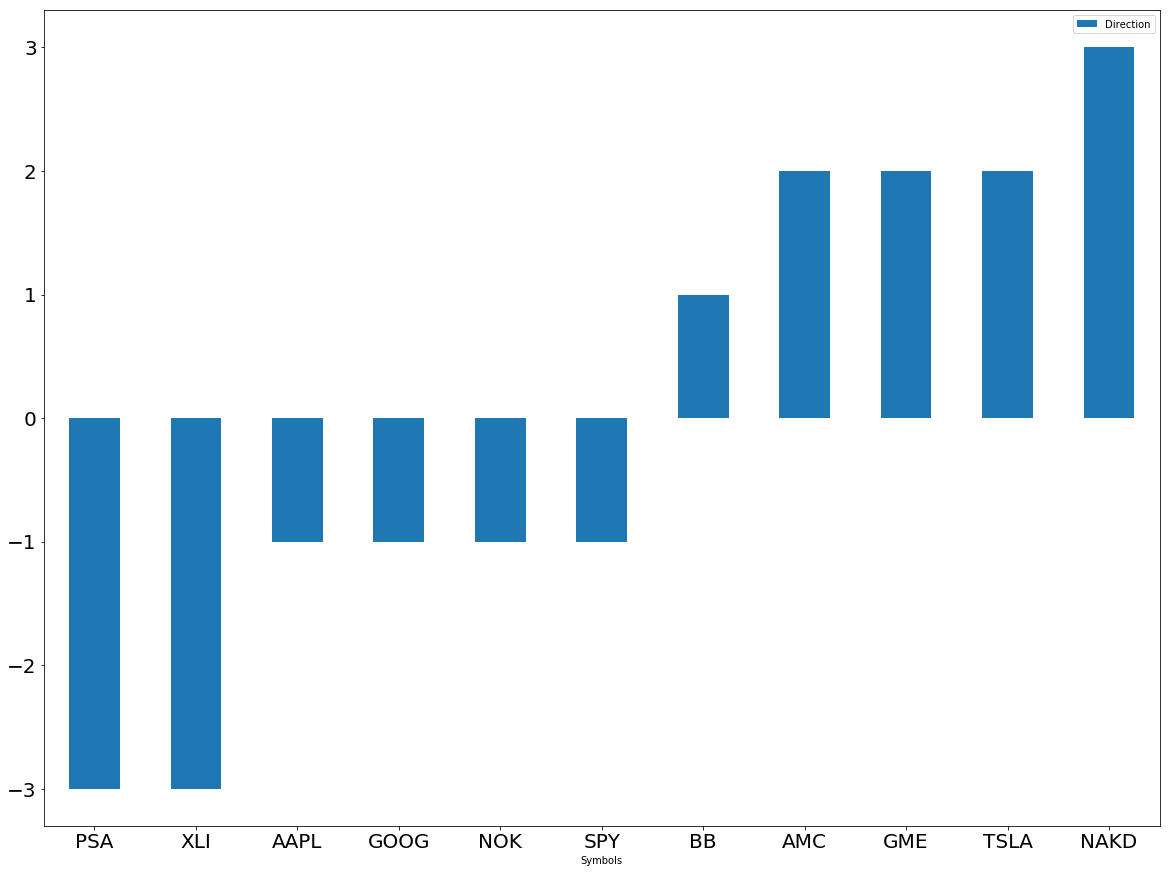

In [26]:
combined.sort_values(by='Direction').plot.bar(figsize=(20,15), fontsize=20, rot=0)


# Telegram Notification


In [87]:
tf=pd.read_csv('telegram.csv')
key=tf.iloc[0,0]
chat_id= tf.iloc[0,1]

-523735213

In [84]:
bot=Bot(key)
updater=Updater(key, use_context=True)

In [88]:
def get_stock(summary, key, chat_id):
    summary=str(summary)
    key=str(key)
    chat_id=str(chat_id)
    send_table='https://api.telegram.org/bot' + key + '/sendMessage?chat_id=' + chat_id + '&parse_mode=Markdown&text=' + summary
    response=requests.get(send_table)


In [89]:
get_stock(combined, key, chat_id)

{'ok': True,
 'result': {'message_id': 42,
  'from': {'id': 1625635210,
   'is_bot': True,
   'first_name': 'stock_notification',
   'username': 'clarastockbot'},
  'chat': {'id': -523735213,
   'title': 'Market Neutral',
   'type': 'group',
   'all_members_are_administrators': True},
  'date': 1613898636,
  'text': 'Direction\nSymbols           \nNAKD             3\nAMC              2\nGME              2\nTSLA             2\nBB               1\nAAPL            -1\nGOOG            -1\nNOK             -1\nSPY             -1\nPSA             -3\nXLI             -3'}}

In [ ]:
#while True:
 #   getStock(combined)
   # time.sleep(216000)


# Production Script
Do not touch this part

In [169]:
%%writefile prod.py
import pandas as pd
import pandas_datareader
from pandas_datareader import get_data_yahoo as yh
import itertools

# Define variables and inputs:
asset_count=5
ma_short=15
ma_long=50
pv_period=5


myassetlist = input('Assets here, separated by commas: ')
myassetlist = myassetlist.split(',')

use_internal_data = input('Use Internal Data csv file? - reply y/n: ')


if use_internal_data == 'y':
    df = pd.read_csv('data.csv')[myassetlist]
else:
    df = yh(myassetlist)['Close'] # Get close prices
    df.combine_first(pd.read_csv('data.csv', index_col = 'Date', parse_dates=True)).to_csv('data.csv') #update local data source
    


# Get 20 day returns and rank
ranked_assets = pd.DataFrame(df.pct_change(20).mean().sort_values(ascending = False)) # Ascending to descending returns
ranked_assets # full assets

#moving average short/long term
ranked_ma_assets = pd.DataFrame(((df.tail(ma_short).mean()-df.tail(ma_long).mean())/df.tail(ma_long).mean()).sort_values(ascending = False))
ranked_ma_to_trade = pd.concat([ranked_ma_assets.head(asset_count),ranked_ma_assets.tail(asset_count)])
ranked_ma_to_trade['Direction']= -1
for row in ranked_ma_to_trade.head(asset_count):
    ranked_ma_to_trade.head(asset_count)['Direction']= 1
ranked_ma_to_trade.columns = ['MA_strategy','Direction']
# ranked_ma_to_trade

#Price ratio
#list(itertools.combinations(myassetlist, 2))

#VPT indicator
vf=yh(myassetlist)['Volume']
ranked_pv_assets = pd.DataFrame(((vf*df.pct_change()).cumsum()).pct_change(pv_period).tail(1).sum().sort_values(ascending = False))
ranked_pv_to_trade = pd.concat([ranked_pv_assets.head(asset_count),ranked_pv_assets.tail(asset_count)])
ranked_pv_to_trade['Direction']= -1
for row in ranked_pv_to_trade.head(asset_count):
    ranked_pv_to_trade.head(asset_count)['Direction']= 1
ranked_pv_to_trade.columns = ['VPT_strategy','Direction']
# ranked_pv_to_trade

long = ranked_assets[0:asset_count] # top 2 assets
long['Direction'] = 1
long.columns = ['20_day_returns','Direction']
# long

short = ranked_assets[-asset_count:] # bottom 2 assets
short['Direction'] = -1
short.columns = ['20_day_returns','Direction']
# short

assets_to_trade = pd.concat([long,short])

combined = pd.DataFrame(pd.concat([assets_to_trade,ranked_ma_to_trade,ranked_pv_to_trade])['Direction'])
combined = combined.reset_index()
combined = combined.groupby('Symbols').sum()

print('Results')
print(combined)
combined.sort_values(by='Direction').plot.bar(figsize=(20,15), fontsize=20, rot=0)

Overwriting prod.py
